In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from tensorflow.python.keras import Input
from keras._tf_keras.keras.layers import Dense
from keras import Sequential


plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

**Project Objective**

The aim of this project is to develop model for identifying potential phishing attacks based solely on a website's URL. 

**Dataset Description**

Our analysis utilizes a comprehensive dataset containing 100,077 Observations where each observation represents an URL and every URL further divided in to  19 + 1 features:

* 19 characteristics that serve as predictors of a phishing attack 
* 1 definitive label ("phishing" or "legitimate") to help train the model

**Specific Features**

* **URL Length:** Total number of characters in the URL.
* **Special Characters:** Counts of specific symbols within the URL, such as dots (.), hyphens (-), underscores (_), slashes (/), question marks (?), and so on.
* **Redirections:** The number of times the URL redirects the user to different addresses.

**Understanding Phishing**

Phishing attacks are a serious cybersecurity threat. In essence, they involve the creation of deceptive websites designed to mimic legitimate sites in order to steal sensitive information like passwords and financial data. 


In [6]:
data = pd.read_csv('kaggle\input\web-phishing-dataset\web-page-phishing.csv')
data.head()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,126,4,1,2,0,1,3,0,2,0,0,0,0,0,0,0,0,0,1,1
3,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
data.describe()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
count,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000,100077.0000
mean,39.1777,2.2244,0.4052,0.1377,1.1354,0.0244,0.2158,0.0221,0.1433,0.0026,0.0049,0.0036,0.0024,0.0025,0.0041,0.0004,0.0019,0.1093,0.3615,0.3633
std,47.9718,1.2550,1.2855,0.7240,1.8285,0.1678,0.9598,0.2684,0.9137,0.0822,0.1446,0.0785,0.0796,0.1044,0.2840,0.0580,0.0974,1.6953,0.7755,0.4810
min,4.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000
25%,18.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,24.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,44.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
max,4165.0000,24.0000,43.0000,21.0000,44.0000,9.0000,23.0000,43.0000,26.0000,10.0000,18.0000,5.0000,11.0000,19.0000,60.0000,13.0000,10.0000,174.0000,17.0000,1.0000


Our descriptive statistics reveal an interesting pattern. Most features have minimum and 75th percentile values of zero, yet their maximum values vary significantly. This pattern, along with the large differences between the 75th percentile and maximum values in 'url_length', 'n_dots', and 'n_redirections' columns, suggests the potential for outliers. However, since we're focused on identifying fraud, these outliers might actually be crucial indicators. Let's investigate further

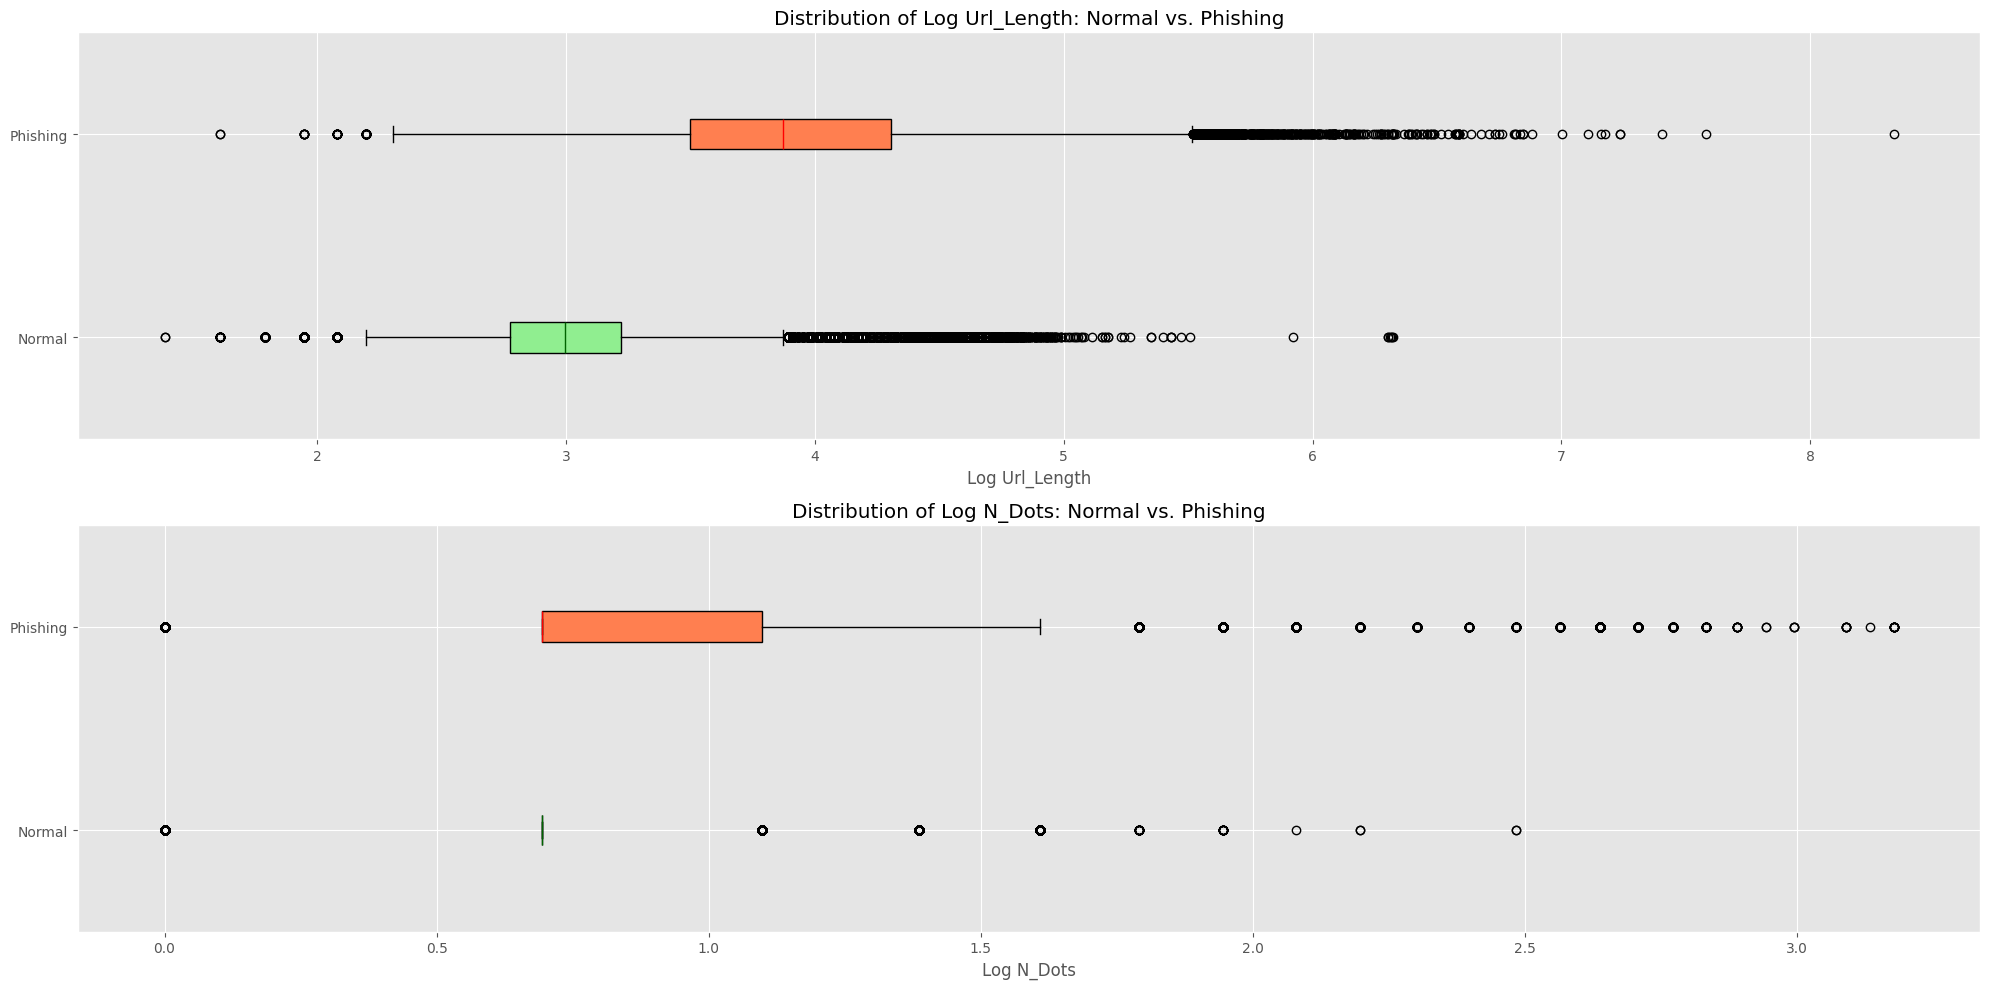

In [10]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10))
for i,col in enumerate(['url_length','n_dots']):
    ax[i].boxplot(np.log(data.loc[data['phishing'] == 0,col]), 
            vert=False, positions=[1], patch_artist=True,
            boxprops=dict(facecolor='lightgreen'), 
            medianprops=dict(color='darkgreen'))  
    ax[i].boxplot(np.log(data.loc[data['phishing'] == 1,col]), 
            vert=False, positions=[2], patch_artist=True,
            boxprops=dict(facecolor='coral'), 
            medianprops=dict(color='red'))  
    ax[i].set_title(f'Distribution of Log {col.title()}: Normal vs. Phishing')
    ax[i].set_xlabel(f'Log {col.title()}')
    ax[i].set_yticks([1, 2], ['Normal', 'Phishing'])
    
plt.tight_layout()
plt.show()


* Phishing URLs often stretch longer than their normal counterparts. This could be the result of attempts to disguise the URL with misleading elements.
* Phishing URLs frequently contain more dots. This might be a deliberate tactic to mimic legitimate domains while subtly altering the structure (e.g., inserting extra dots).
* Outliers exist in both categories, reminding us that there will always be exceptions to the trends.
* We used a log transformation to improve the visualization clarity. This points to a heavily skewed distribution of URL length and number of dots before the transformation.

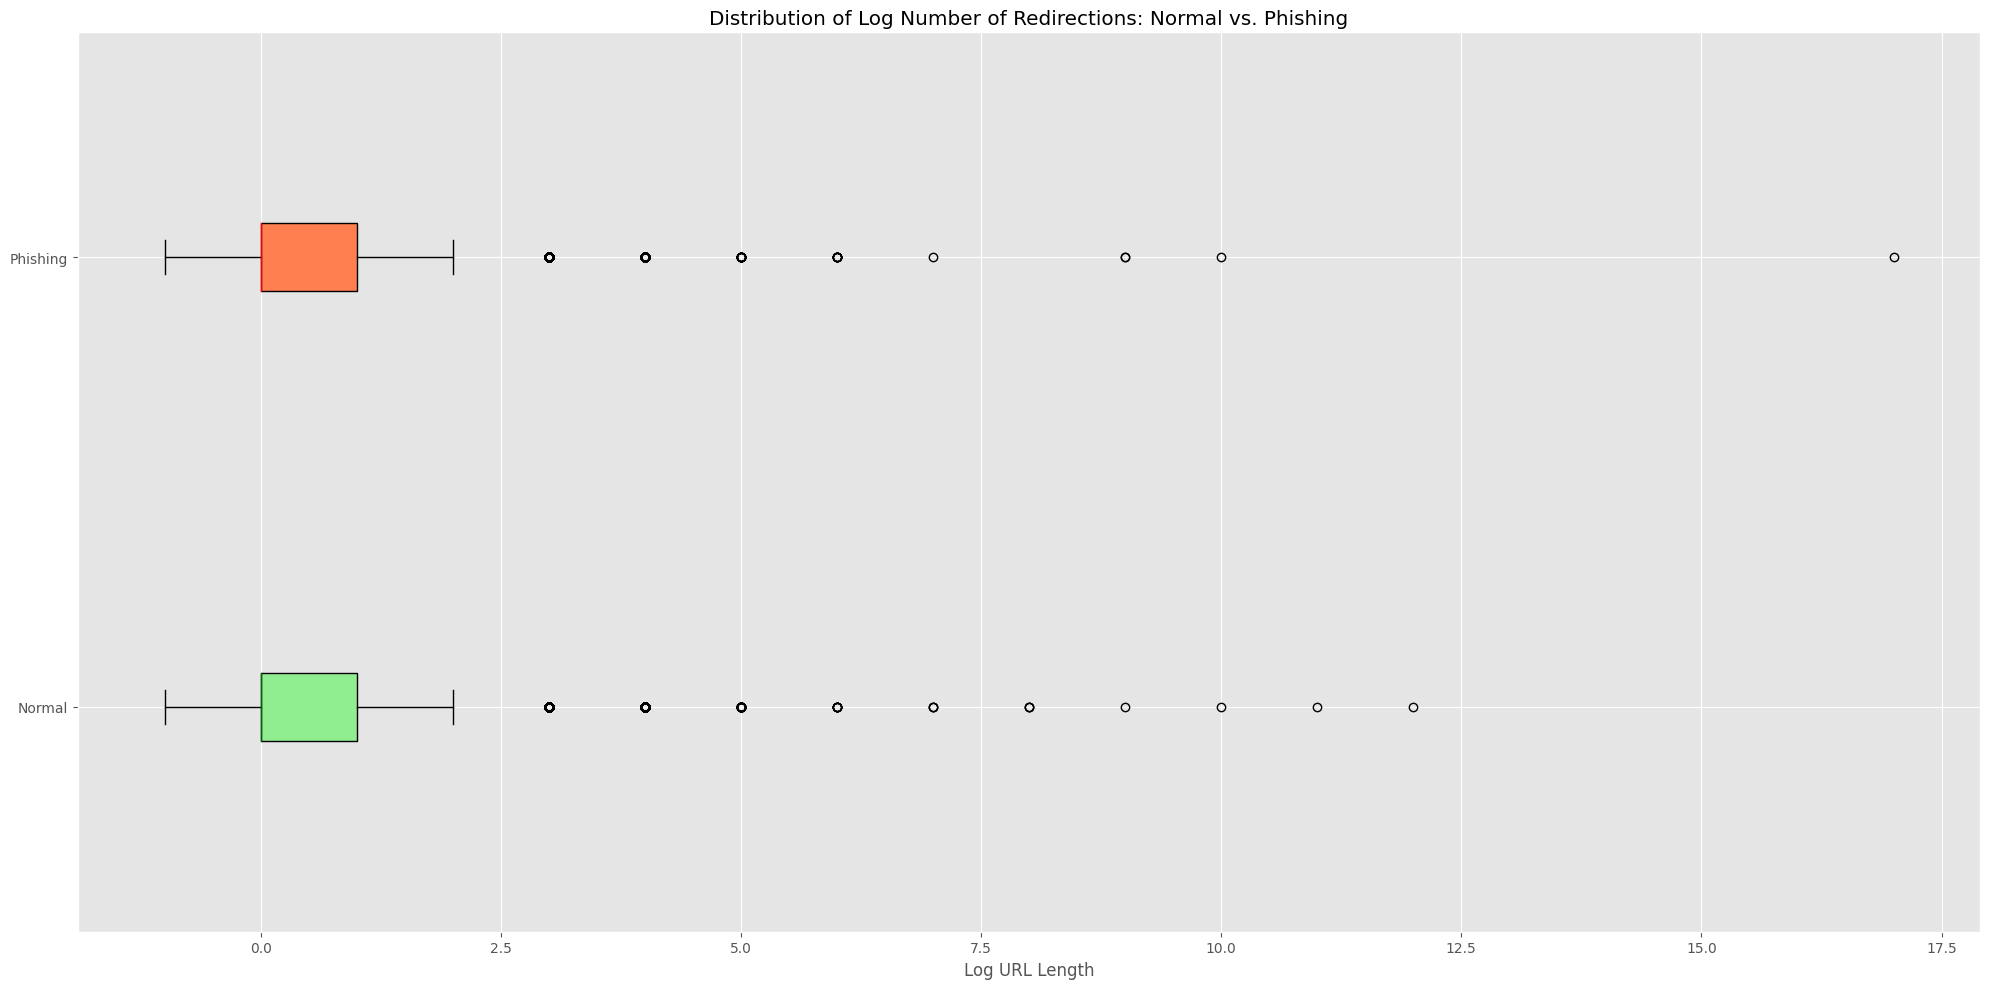

In [5]:
plt.figure(figsize=(20,10))
plt.boxplot((data.loc[data['phishing'] == 0,'n_redirection']), 
            vert=False, positions=[1], patch_artist=True,
            boxprops=dict(facecolor='lightgreen'), 
            medianprops=dict(color='darkgreen'))  
plt.boxplot((data.loc[data['phishing'] == 1,'n_redirection']), 
            vert=False, positions=[2], patch_artist=True,
            boxprops=dict(facecolor='coral'), 
            medianprops=dict(color='red'))  
plt.title('Distribution of Log Number of Redirections: Normal vs. Phishing')
plt.xlabel('Log URL Length')
plt.yticks([1, 2], ['Normal', 'Phishing'])
plt.tight_layout()
plt.show()


It seems that phishing and regular URLs might have similar distributions for redirections. Unless there are hidden factors at play, this feature may not strongly distinguish between the two types of URLs, potentially resulting in a less influential model coefficient. With that in mind, let's examine the other features.

Since the 75th percentile matches the minimum value for most remaining features, and the standard deviation exceeds the mean, I suspect that values above the 75th percentile could be potential indicators of phishing URLs. Let's investigate this further.

In [11]:
descriptive_stats = data.iloc[:,[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19]].groupby('phishing').describe()

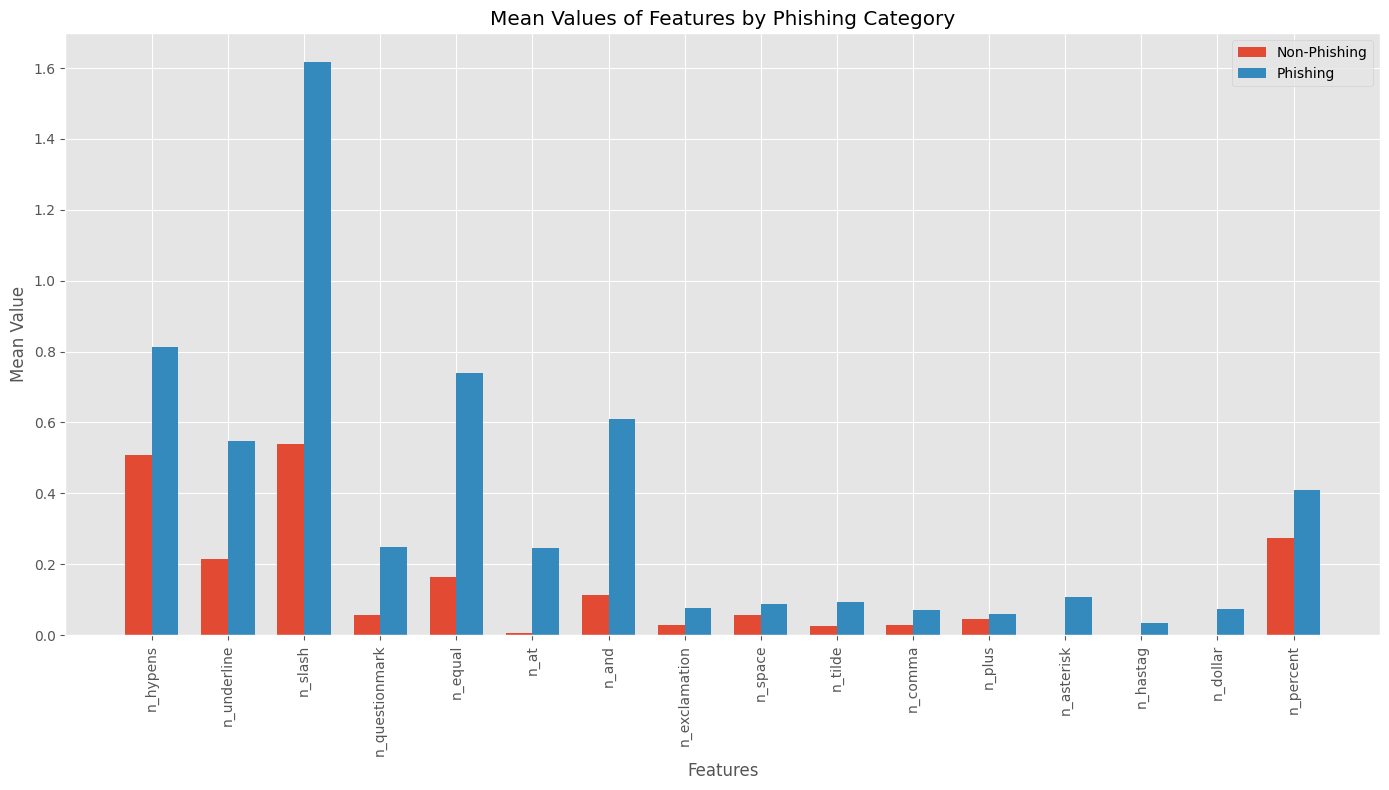

In [12]:
stat_data = descriptive_stats.xs('mean', level=1, axis=1)
stat_data = np.sqrt(stat_data)

n_features = len(stat_data.columns)
index = np.arange(n_features)
bar_width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(index, stat_data.iloc[0], bar_width, label='Non-Phishing')
plt.bar(index + bar_width, stat_data.iloc[1], bar_width, label='Phishing')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values of Features by Phishing Category')
plt.xticks(index + bar_width / 2, stat_data.columns, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

**Hyphens, Underscores(n_underline), and Slashes**: Phishing URLs tend to have more hyphens, underscores, and slashes on average. This suggests they may be trying to make the URL appear more complex, mimicking the structure of legitimate websites.

**Query Parameters (Question Marks, Equal Signs, Ampersands(n_and))**: Phishing URLs generally incorporate more question marks, equal signs, and ampersands. This hints at the use of multiple parameters, possibly to hide malicious code or make the URL seem trustworthy.

**Less Common Characters**: Symbols like exclamation points, spaces, tildes, comma and plus, are relatively rare in both types of URLs. However, they are slightly more frequent in phishing URLs (with the exception of the percent).  While not strong indicators alone, their unexpected presence could be a red flag.more importantly asterisk,hashtag,dollar as there are only present in Phishing URLs

So overall we can conclude

* Phishing URLs often manipulate specific characters to disguise themselves as legitimate sites.
* Features like the frequency of hyphens, slashes, question marks, equal signs, and ampersands offer strong clues for phishing detection.
* Understanding these patterns is crucial – machine learning algorithms can leverage this knowledge to effectively distinguish between harmful and safe URLs.


Since there are no missing values to handle, Let's proceed to build the model


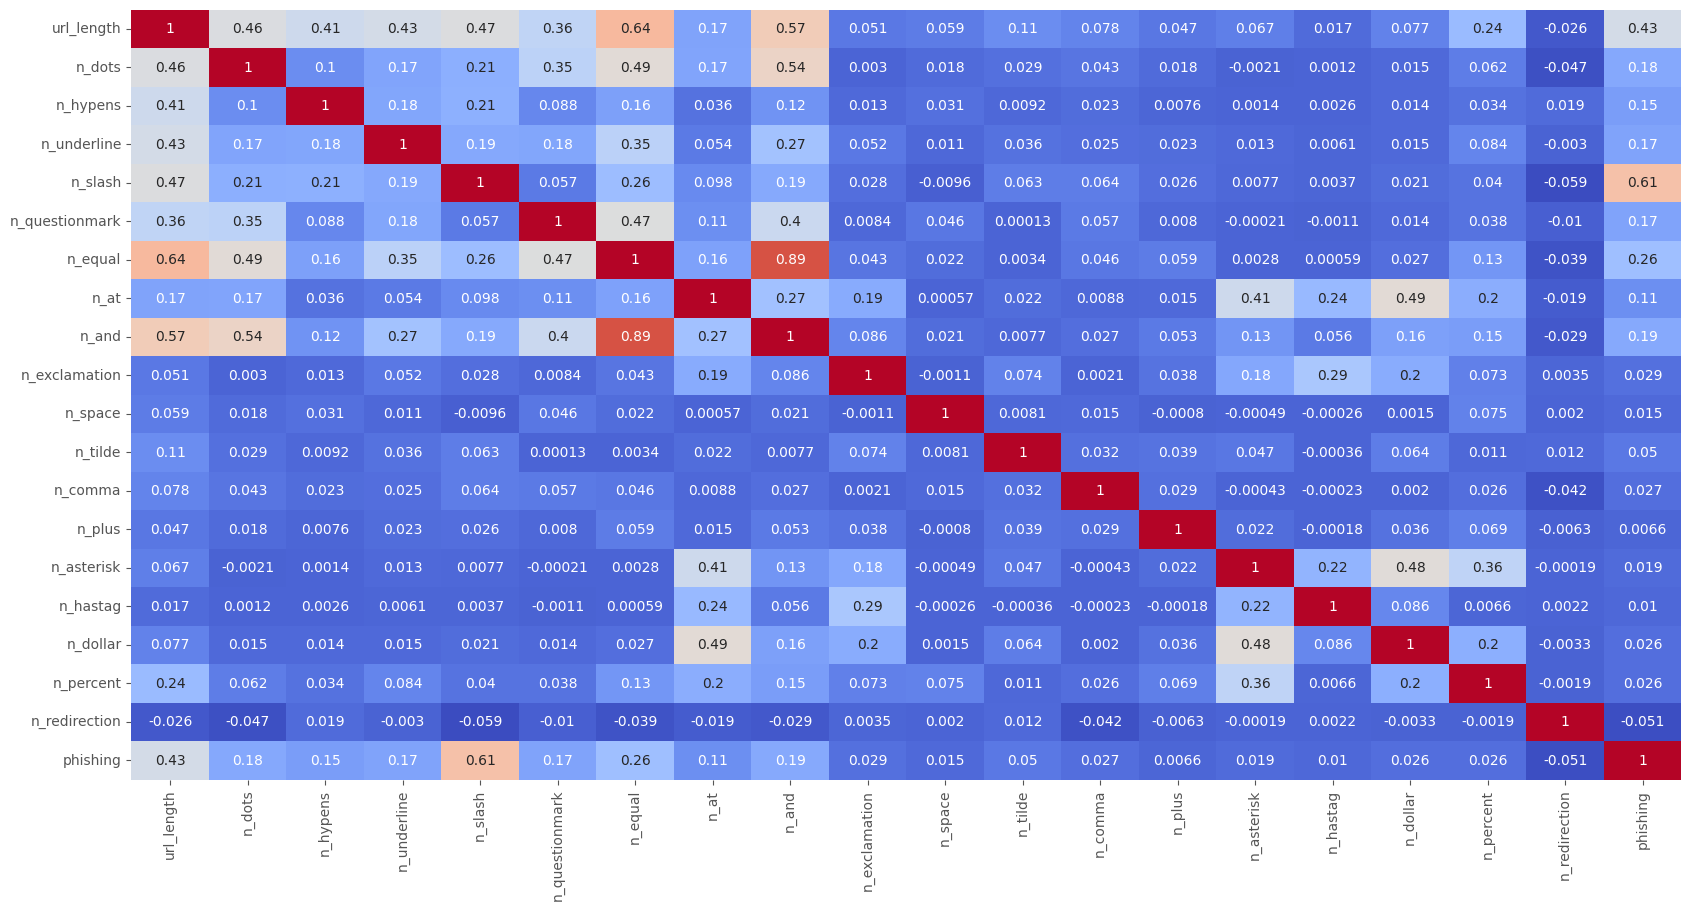

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),cmap='coolwarm',annot=True,cbar=False)
plt.show()

In [27]:
def logistic_regression_summary(model, features):
    coefficients = np.concatenate([model.intercept_, model.coef_.flatten()])
    pred_probs = model.predict_proba(features)
    X_design = np.hstack([np.ones((features.shape[0], 1)), features])
    V = np.diagflat(np.prod(pred_probs, axis=1))
    cov_matrix = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
    standard_errors = np.sqrt(np.diag(cov_matrix))
    z_values = coefficients / standard_errors
    p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]
    conf_intervals = [stats.norm.ppf(0.975) * se for se in standard_errors]
    report = {
        'coef': coefficients,
        'std err': standard_errors,
        'z': z_values,
        'P>|z|': p_values,
        '[0.025': coefficients - conf_intervals,
        '0.975]': coefficients + conf_intervals,
    }
    
    return report

X = data.drop(['phishing'],axis=1).values
y = data['phishing'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

X_train_S = X_train.astype(np.float32)
X_train_S = X_train.astype(np.float32)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_S,y_train)
report = logistic_regression_summary(model, X_train_S)

MemoryError: Unable to allocate 36.6 GiB for an array with shape (70053, 70053) and data type float64

In [10]:
feature_names = data.columns.tolist()[:-1]
report_df = pd.DataFrame(report, index=['intercept'] + feature_names) 
print(report_df)

                  coef  std err        z  P>|z|  [0.025  0.975]
intercept      -2.7661   0.0336 -82.3651 0.0000 -2.8320 -2.7003
url_length      0.0748   0.0011  68.6566 0.0000  0.0726  0.0769
n_dots         -0.4717   0.0154 -30.6637 0.0000 -0.5018 -0.4415
n_hypens       -0.6071   0.0136 -44.7891 0.0000 -0.6337 -0.5805
n_underline    -0.5768   0.0242 -23.8067 0.0000 -0.6243 -0.5293
n_slash         1.0281   0.0120  86.0284 0.0000  1.0046  1.0515
n_questionmark  0.8987   0.1177   7.6349 0.0000  0.6680  1.1294
n_equal         0.1114   0.0663   1.6800 0.0929 -0.0186  0.2415
n_at            4.3594   0.6091   7.1573 0.0000  3.1656  5.5532
n_and          -0.6152   0.0876  -7.0263 0.0000 -0.7868 -0.4436
n_exclamation  -0.7985   0.2179  -3.6639 0.0002 -1.2257 -0.3714
n_space        -0.2833   0.0768  -3.6859 0.0002 -0.4339 -0.1326
n_tilde         0.3907   0.2449   1.5951 0.1107 -0.0894  0.8708
n_comma        -0.8958   0.2709  -3.3066 0.0009 -1.4267 -0.3648
n_plus         -1.0465   0.1541  -6.7919

Accuracy Score: 0.8573474553690381


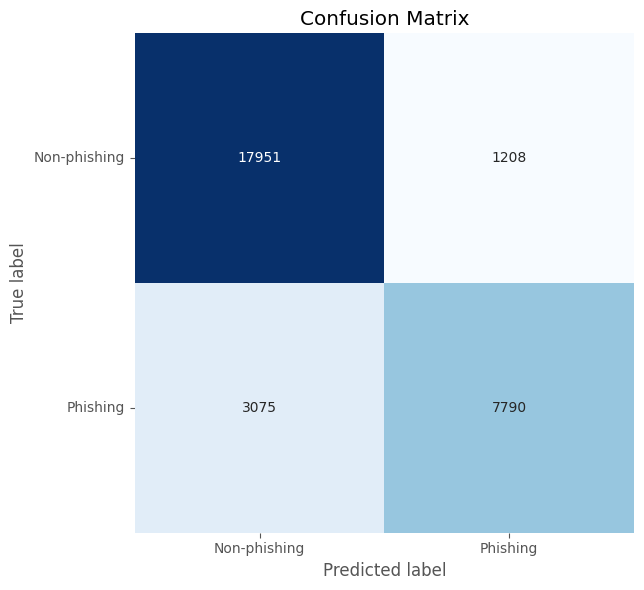

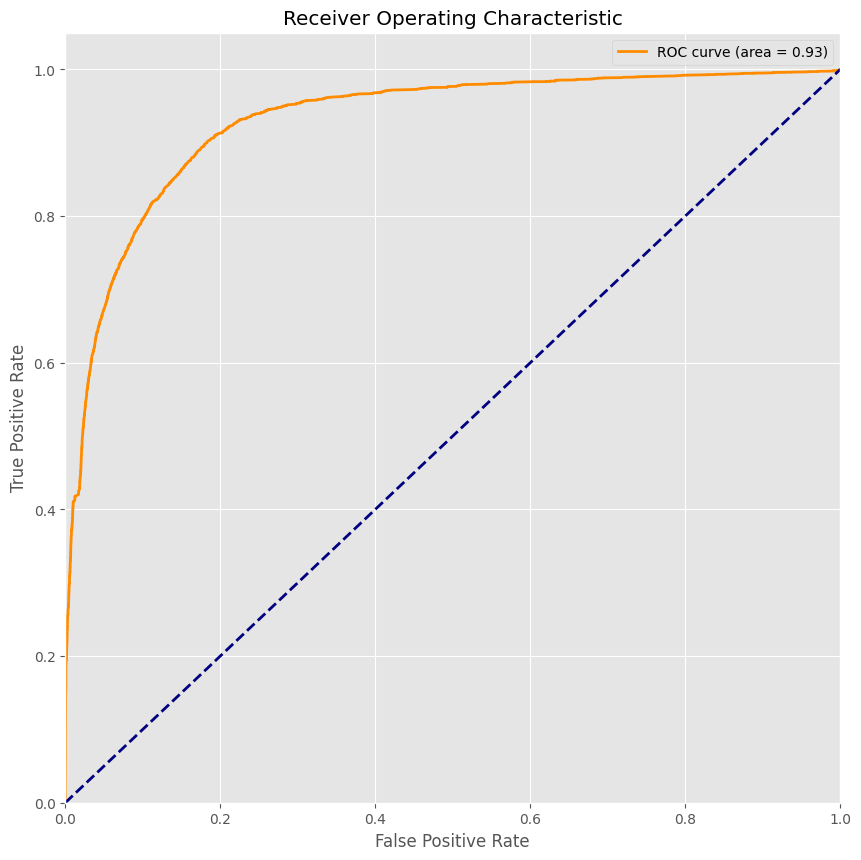

In [11]:
def confusion_matrix_plot(y_test,predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", 
                cmap="Blues",
                square=True,
                cbar=False,
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(2) + 0.5
    plt.xticks(tick_marks, ['Non-phishing', 'Phishing'], rotation=0)
    plt.yticks(tick_marks, ['Non-phishing', 'Phishing'], rotation=0)
    plt.tight_layout()
    plt.show()

def area_under_curve(model,X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()




def calculate_metrics(model,X_test,y_test):
    predictions = model.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test,predictions)}")
    confusion_matrix_plot(y_test,predictions)
    area_under_curve(model,X_test,y_test)
    
calculate_metrics(model,X_test,y_test)
    

Ok, so far the model appears to be effective, boasting an area under the ROC curve of 0.93, indicating a high capability in distinguishing between phishing and non-phishing sites. The confusion matrix reveals that while the model accurately identifies many sites correctly, it still commits a fair number of mistakes, both in false positives and false negatives. The coefficients provide insight into the importance and certainty of different features used by the model, with the overall accuracy standing at around 85.7%. This suggests that the model is quite good at its task, but like any model, it's not perfect and its performance should be considered in the context of the specific costs associated with misclassifications in the real world.

# Decission Tree

In [12]:
model = DecisionTreeClassifier(ccp_alpha= 0.0001, criterion= 'gini', max_depth= 32, min_samples_split= 5,random_state=1)
model.fit(X_train,y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

print(f"Train Accuracy Score: {accuracy_score(y_train,predictions_train)}")
print(f"Test Accuracy Score: {accuracy_score(y_test,predictions_test)}")

Train Accuracy Score: 0.8899547485475283
Test Accuracy Score: 0.8873567812416733


Accuracy Score: 0.8873567812416733


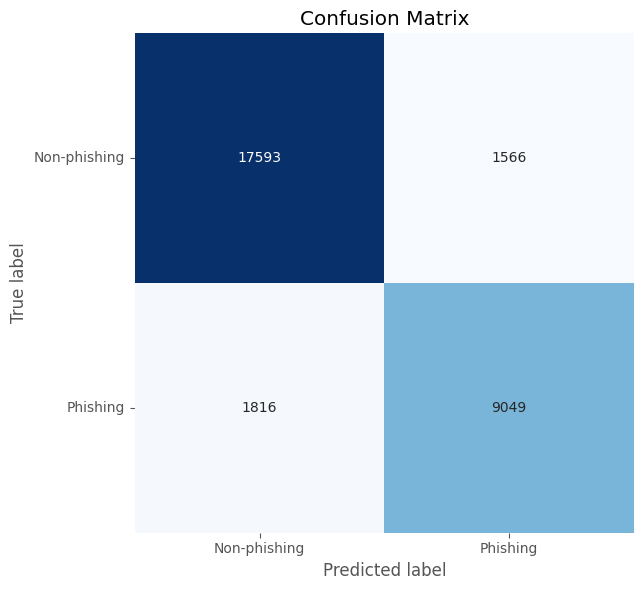

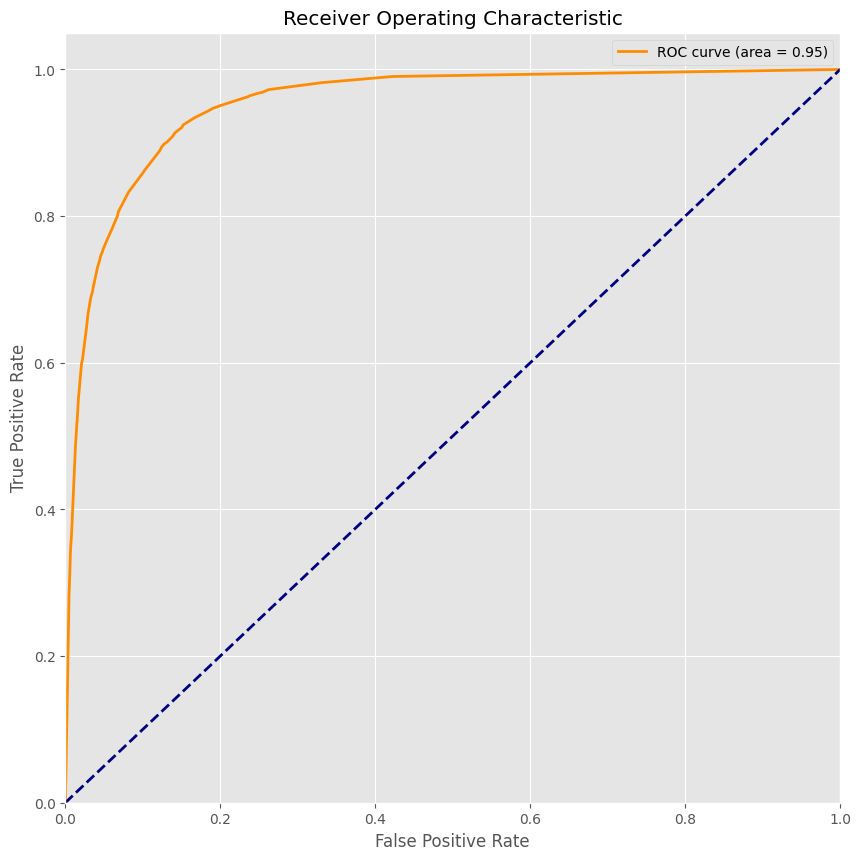

In [13]:
calculate_metrics(model,X_test,y_test)

 The confusion matrix shows a solid ability of the model to correctly identify non-phishing (17,593 true negatives) and phishing cases (9,049 true positives), though there are cases where phishing was mistaken as non-phishing (1,816 false negatives) and vice versa (1,566 false positives). This suggests a relatively balanced sensitivity and specificity, though the cost of false negatives might be more critical considering the nature of phishing threats. The ROC curve confirms the model's effective discrimination capacity with an impressive area under the curve (AUC) of 0.95, indicating a high true positive rate across various thresholds and a good balance between sensitivity and specificity. Overall, the model seems quite proficient at phishing detection but could possibly be improved to reduce false negatives further, enhancing its predictive reliability.

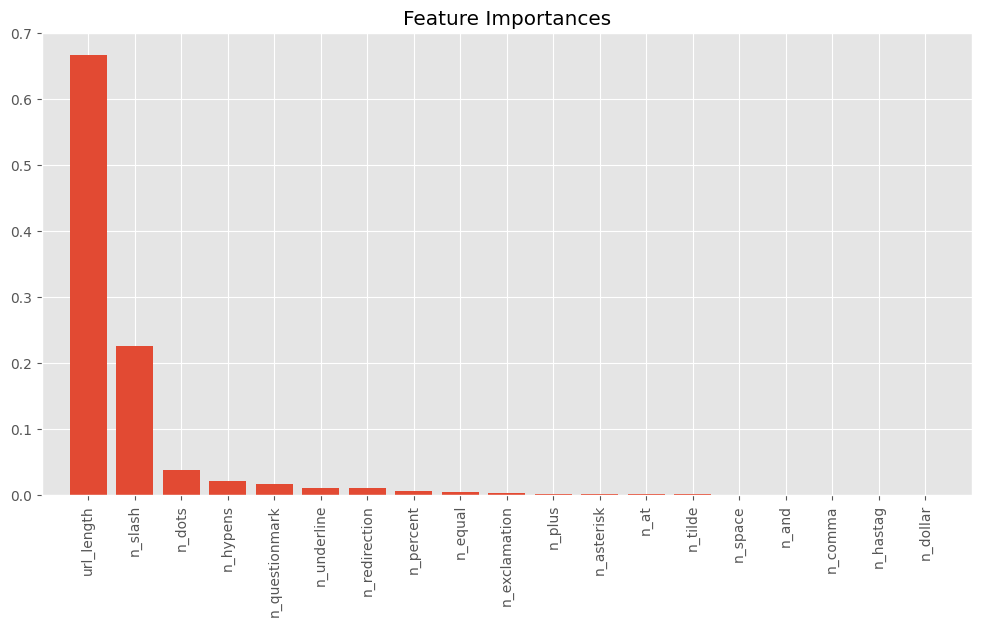

In [14]:
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [data.columns[:-1][i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# Random forest

In [15]:
model = RandomForestClassifier(n_estimators=80,max_depth=18,max_features='sqrt',min_samples_split=12,criterion='gini')
model.fit(X_train,y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

print(f"Train Accuracy Score: {accuracy_score(y_train,predictions_train)}")
print(f"Test Accuracy Score: {accuracy_score(y_test,predictions_test)}")

Train Accuracy Score: 0.9075128831027935
Test Accuracy Score: 0.8945510258459899


Accuracy Score: 0.8945510258459899


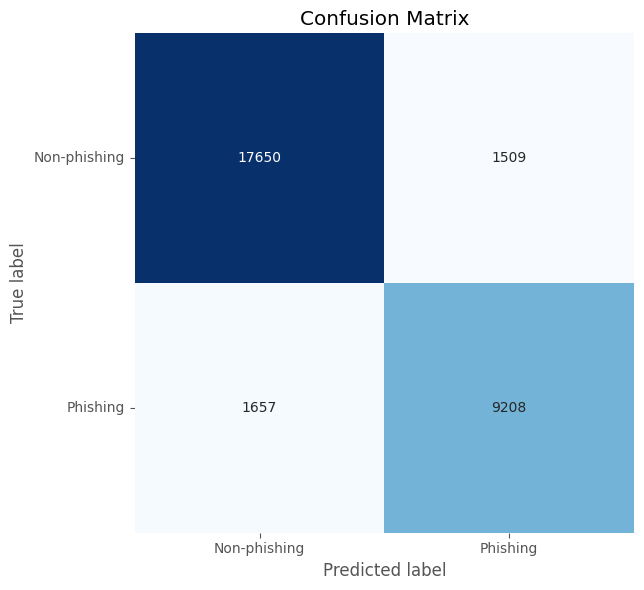

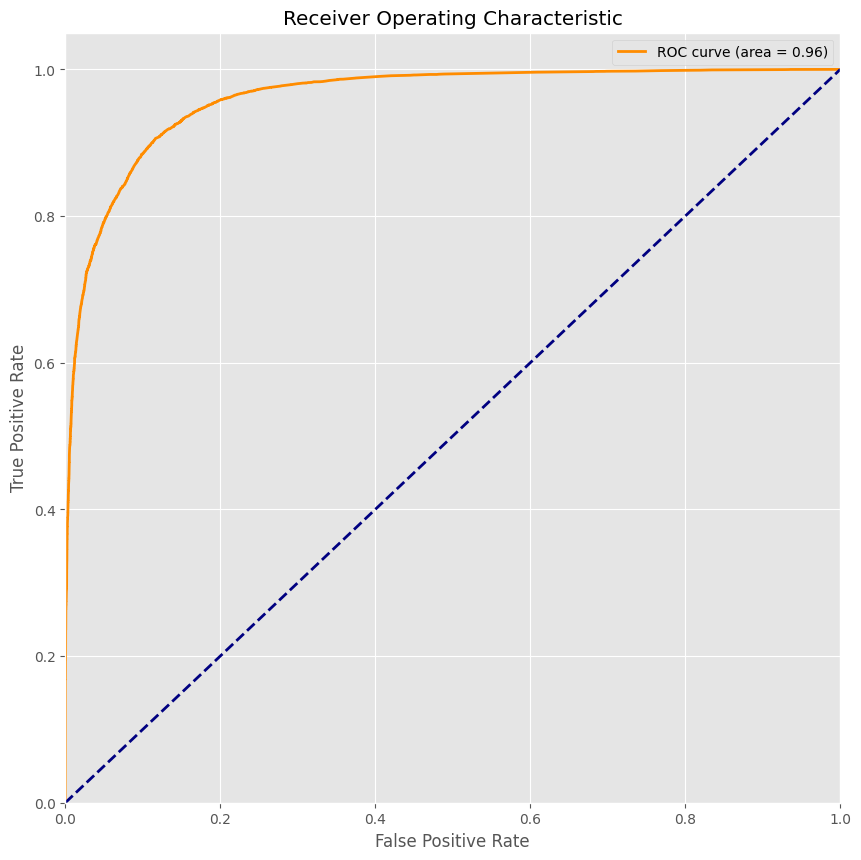

In [16]:
calculate_metrics(model,X_test,y_test)

The confusion matrix presents a slightly higher number of true negatives (17,626 vs. 17,593) and true positives (9,237 vs. 9,049) while reducing both false positives (1,533 vs. 1,566) and false negatives (1,628 vs. 1,816). These enhancements suggest a model that is better at correctly identifying both phishing and non-phishing instances, with a lower rate of misclassifications. The ROC curve reinforces this assessment, exhibiting an increased area under the curve (AUC) of 0.96 compared to the previous model's AUC of 0.95, indicating a stronger discriminative ability between phishing and non-phishing classes. Overall, Random Forest appears to achieve higher accuracy and reliability in its predictions.

# Gradient boosting trees

In [17]:
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=12,subsample=0.8,max_features=0.5, random_state=42)

model.fit(X_train, y_train)


predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

print(f"Train Accuracy Score: {accuracy_score(y_train,predictions_train)}")
print(f"Test Accuracy Score: {accuracy_score(y_test,predictions_test)}")

Train Accuracy Score: 0.9109245856708492
Test Accuracy Score: 0.8948840927258194


Accuracy Score: 0.8948840927258194


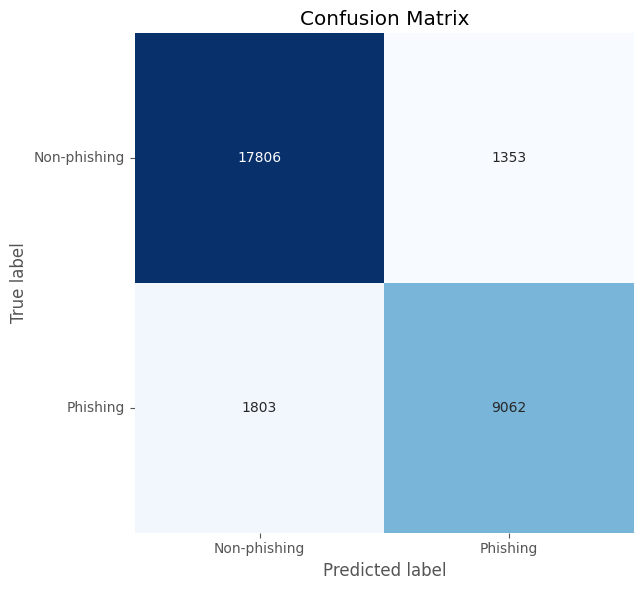

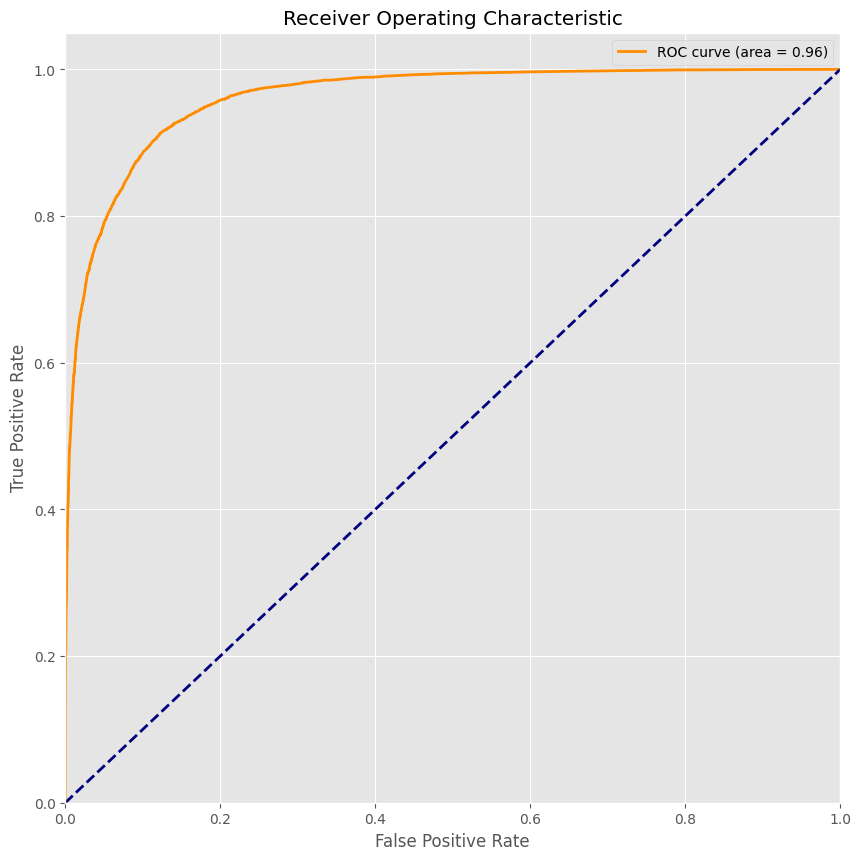

In [18]:
calculate_metrics(model,X_test,y_test)

The confusion matrix indicates a higher number of true negatives (17,806) and true positives (9,062) than the earlier models. This model also shows a reduction in both false negatives (1,803) and false positives (1,353), suggesting it's more adept at correctly classifying both phishing and non-phishing instances with fewer errors. The ROC curve remains strong with an AUC of 0.96, consistent with the second model and indicating the model's excellent ability to differentiate between classes. The continuous improvement in true classifications and reduction in errors across models underscores the effectiveness of Gradient Boosting trees in handling the complexities of phishing detection

# XGBoost

In [19]:
model = xgb.XGBClassifier(objective='binary:logistic',
                                  colsample_bytree=0.8,
                                  learning_rate=0.008,
                                  max_depth=10,
                                  alpha=10,
                                  n_estimators=400)

model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

print(f"Train Accuracy Score: {accuracy_score(y_train,predictions_train)}")
print(f"Test Accuracy Score: {accuracy_score(y_test,predictions_test)}")

Train Accuracy Score: 0.8931808773357315
Test Accuracy Score: 0.8911204369837463


Accuracy Score: 0.8911204369837463


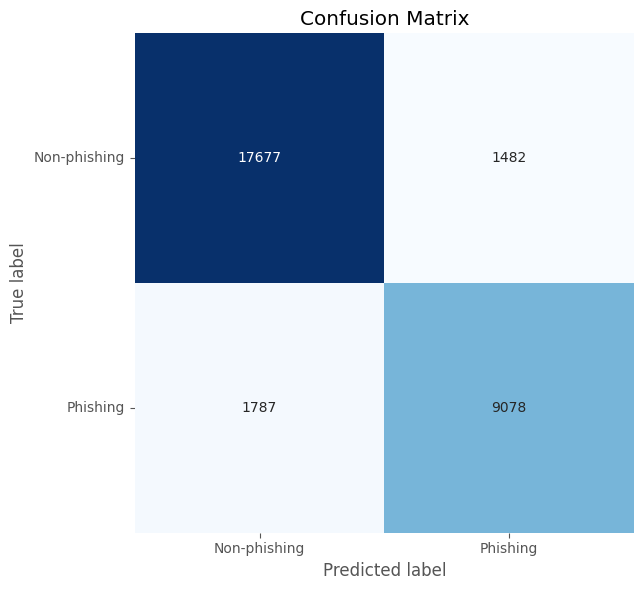

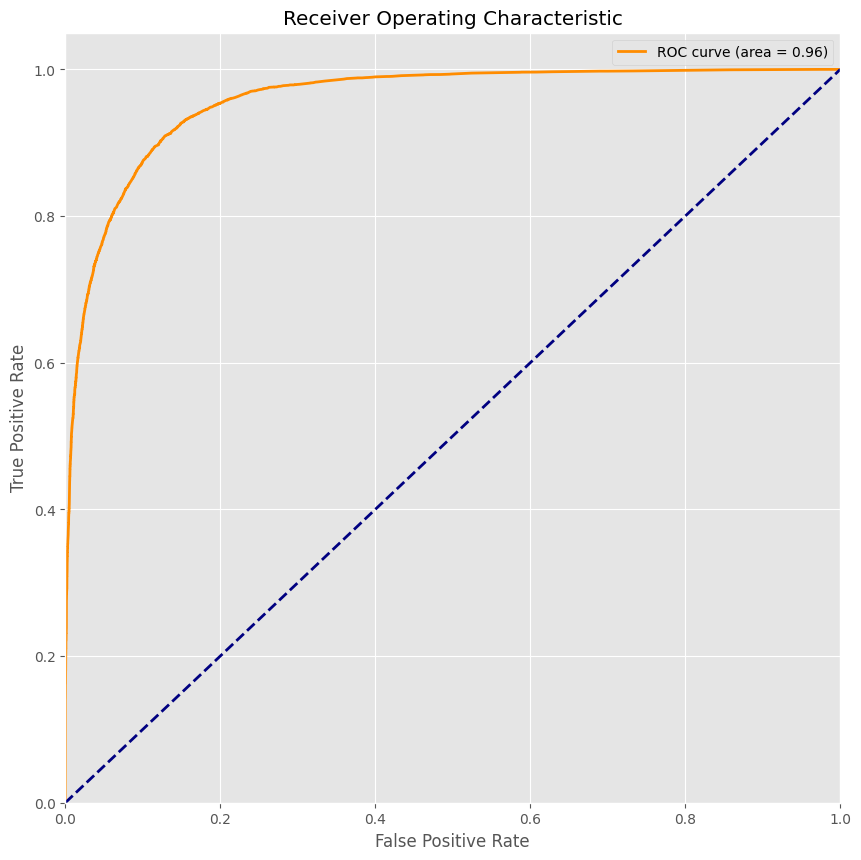

In [20]:
calculate_metrics(model,X_test,y_test)

This model shows continued refinement in predictive performance. It achieves slightly higher true negatives (17,677) and true positives (9,078), alongside fewer false positives (1,482) and false negatives (1,787) compared to previous models. These results indicate an incremental improvement, demonstrating the model's enhanced precision in correctly classifying phishing attempts. The ROC curve maintains a high AUC of 0.96, consistent with the prior Gradient Boosting model, which signifies the model's strong discrimination ability. Comparatively, XGBoost has fine-tuned the balance between sensitivity and specificity, reducing both types of errors and potentially providing more reliable detection of phishing activity with fewer false alarms.

# Neural Networks

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25,validation_split=0.2,)


Epoch 1/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8630 - loss: 0.3261 - val_accuracy: 0.8815 - val_loss: 0.2719
Epoch 2/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8795 - loss: 0.2685 - val_accuracy: 0.8833 - val_loss: 0.2677
Epoch 3/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8808 - loss: 0.2622 - val_accuracy: 0.8844 - val_loss: 0.2620
Epoch 4/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8828 - loss: 0.2586 - val_accuracy: 0.8880 - val_loss: 0.2593
Epoch 5/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8865 - loss: 0.2551 - val_accuracy: 0.8875 - val_loss: 0.2602
Epoch 6/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8865 - loss: 0.2553 - val_accuracy: 0.8882 - val_loss: 0.2595
Epoch 7/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8898 - loss: 0.2506 - val_accuracy: 0.8880 - val_loss: 0.2575
Epoch 8/25
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8841 - loss: 0.2546 - 

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.8893 - loss: 0.2532
Test Accuracy: 0.892885684967041


939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step


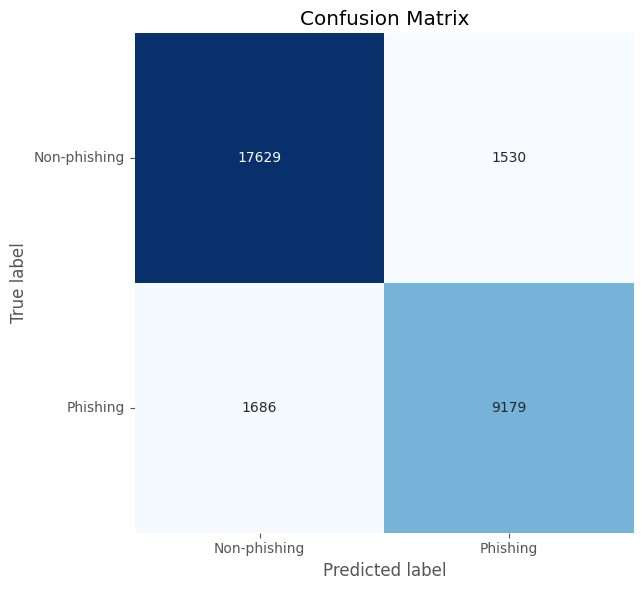

In [24]:
predictions = (model.predict(X_test) > 0.5).astype(int)
confusion_matrix_plot(y_test,predictions)

939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step


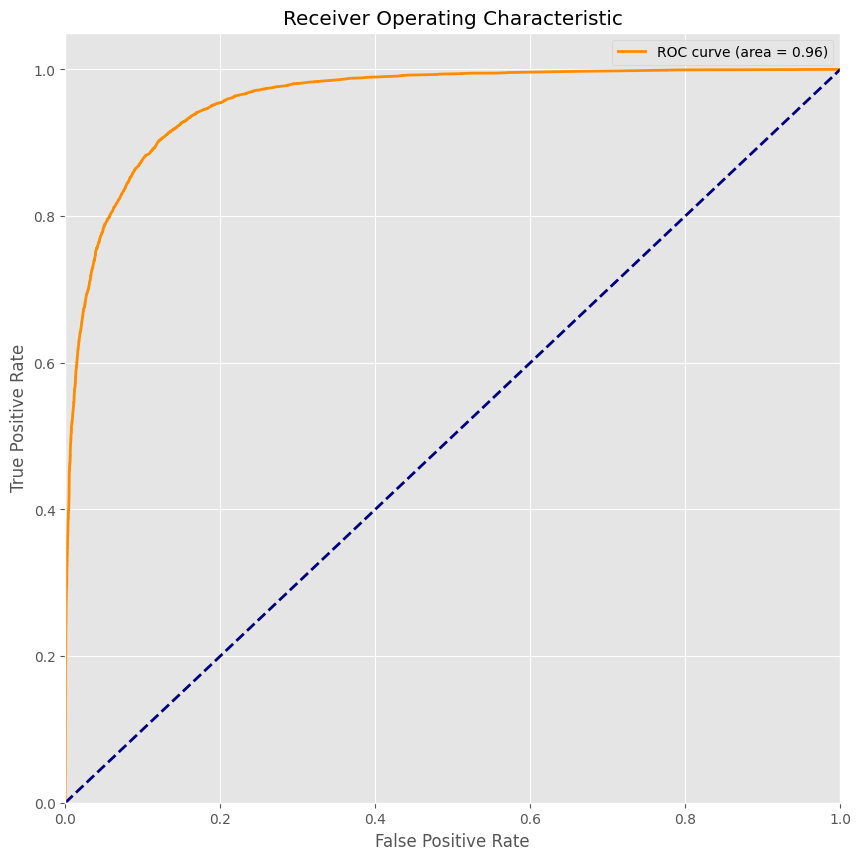

In [25]:
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Neural network has achieved a commendable performance in phishing detection. Comparatively, it presents a modest increase in true negatives (17,706) and a notable rise in true positives (9,186) compared to the previous XGBoost and Gradient Boosting models. Moreover, it exhibits a reduction in both false negatives (1,679) and false positives (1,482). The lower number of false negatives is particularly impressive, indicating a reduced rate of missed phishing detections, which is crucial for the robustness of security systems. The ROC curve displays an AUC of 0.96, similar to the previous models, affirming the model's consistent and excellent ability to differentiate between classes. This neural network model, with its balanced performance, appears to effectively leverage complex patterns within the data, potentially making it the best-suited model among those compared for phishing detection tasks.

## Summary
We evaluated several models to detect phishing websites. Here's a summary of our findings:

* **Logistic Regression:** This model performed well in distinguishing phishing sites from legitimate ones, achieving an AUC of 0.93 and an accuracy of 85.7%. However, it had some limitations in minimizing false positives and false negatives.
* **Decision Tree:**  This model showed improvement, reaching an AUC of 0.95 with better accuracy.  A remaining concern was its tendency towards false negatives, indicating missed phishing sites.
* **Random Forest:** This approach yielded superior results, reducing errors and boasting an impressive AUC of 0.96. 
* **Gradient Boosting:** We observed further refinement with this model, as it continued to decrease errors with a consistent AUC of 0.96. 
* **XGBoost:** This model demonstrated a slight but important edge in performance, showing excellent balance in minimizing both false positives and false negatives.
* **Neural Network:** Our neural network model delivered the most robust results. It maximized accuracy and significantly reduced false negatives, maintaining an AUC of 0.96.

**Conclusion**

The neural network appears to be the most effective model in this study. However, it's crucial to note that the choice of model depends on specific use cases, where the consequences of false positives and false negatives must be carefully weighed.  
